## Sentiment Analysis of English Texts

### Approach: Support Vector Machine(SVM)

#### Importing required libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# NLP libraries
import re
import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords, wordnet
import contractions
from sklearn.feature_extraction.text import TfidfVectorizer

# Downloading necessary datasets from NLTK
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

# Machine Learning libraries
from sklearn import svm
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Chethan\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Chethan\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Chethan\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\Chethan\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


#### Loading the dataset

In [2]:
df = pd.read_csv("IMDB Dataset.csv")
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


#### Exploratory Data Analysis(EDA)

In [3]:
# Shape of the dataset
print(f"This dataset has {df.shape[0]} rows and {df.shape[1]} columns.")

# Statistical figures about the dataset
print("Statistical figures: ")
print(df.describe())

# Count and types of sentiments
print(f"There are {df['sentiment'].nunique()} sentiments in this dataset and they are: ")
for i in range(df['sentiment'].nunique()):
    print(f"{i+1}. {df['sentiment'].unique()[i]}")

This dataset has 50000 rows and 2 columns.
Statistical figures: 
                                                   review sentiment
count                                               50000     50000
unique                                              49582         2
top     Loved today's show!!! It was a variety and not...  positive
freq                                                    5     25000
There are 2 sentiments in this dataset and they are: 
1. positive
2. negative


#### Visualizing the dataset

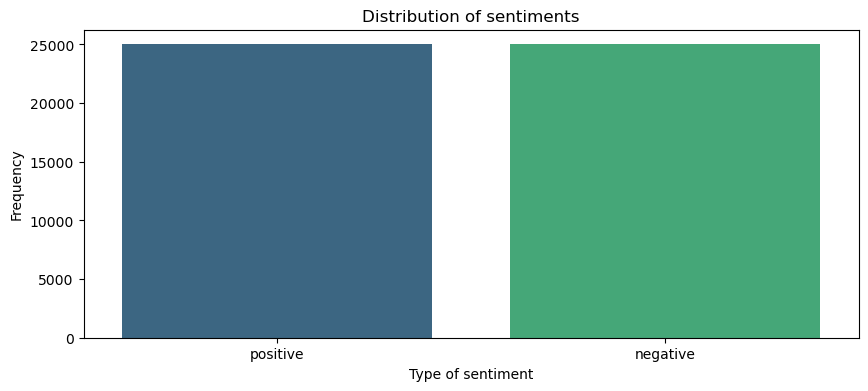

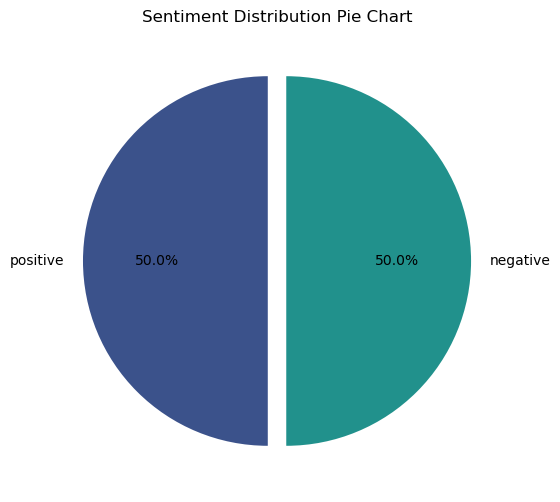

In [4]:
# Frequency plot
plt.figure(figsize = (10, 4))
sns.countplot(data = df, x = df['sentiment'], palette = 'viridis')
plt.title('Distribution of sentiments')
plt.xlabel('Type of sentiment')
plt.ylabel('Frequency')
plt.show()

# Pie chart
plt.figure(figsize = (6, 6))
df['sentiment'].value_counts().plot.pie(autopct = '%1.1f%%', colors = sns.color_palette('viridis', 3), startangle = 90, explode = [0.05]*2)
plt.title('Sentiment Distribution Pie Chart')
plt.ylabel('')
plt.show()

#### Text Preprocessing

In [6]:
import spacy
import unicodedata
from bs4 import BeautifulSoup

##### Data Cleaning

In [7]:
def clean_data(text):    
    # Convert to lowercase
    text = text.lower()
    
    # Tie "not" with the next word to retain the negative sentiment
    text = re.sub(r'\bnot\b \b\w+\b', lambda x: x.group().replace(' ', '_'), text)

    # Remove URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    
    # Remove user @ references and '#' from hashtags
    text = re.sub(r'\@\w+|\#','', text)
    
    # Remove special characters, numbers, and punctuations
    text = re.sub(r'\W', ' ', text)
    text = re.sub(r'\d', ' ', text)
    
    # Remove single characters
    text = re.sub(r'\s+[a-zA-Z]\s+', ' ', text)
    
    # Remove multiple spaces
    text = re.sub(r'\s+', ' ', text)
       
    #Remove HTML tags
    text = BeautifulSoup(text, 'lxml').get_text()
    
    #Remove any emails
    text = re.sub(r'\b[A-Za-z0-9._%+-]+@[A-Za-z0-9.-]+\.[A-Z|a-z]{2,}\b', '', text)
    
    #remove any mentions
    text=re.sub(r'@\w+', '', text).strip()
    
    #remove repeated characters
    text=re.sub(r'(.)\1+', r'\1\1', text)
    

    
    return text.strip()

# Apply cleaning and fix contractions
df['text'] = df['review'].apply(lambda x: contractions.fix(x))
df['clean_text'] = df['text'].apply(clean_data)

# Display cleaned text
df[['review','text', 'clean_text']].head()

,review,text,clean_text
0,One of the other reviewers has mentioned that ...,One of the other reviewers has mentioned that ...,one of the other reviewers has mentioned that ...
1,A wonderful little production. <br /><br />The...,A wonderful little production. <br /><br />The...,a wonderful little production br br the filmin...
2,I thought this was a wonderful way to spend ti...,I thought this was a wonderful way to spend ti...,i thought this was wonderful way to spend time...
3,Basically there's a family where a little boy ...,Basically there is a family where a little boy...,basically there is family where little boy jak...
4,"Petter Mattei's ""Love in the Time of Money"" is...","Petter Mattei's ""Love in the Time of Money"" is...",petter mattei love in the time of money is vis...


##### Tokenization, Lemmatization and Removing Stopwords

In [8]:
# Initialize the lemmatizer object
wnl = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

# Helper function to map POS tag to wordnet POS
def get_wordnet_pos(tag):
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN  # Default to noun
    
# Lemmatization function
def lemmatize_data(text):
    words = word_tokenize(text)
    filtered_words = [word for word in words if word.lower() not in stop_words]
    pos_tagged = nltk.pos_tag(filtered_words)
    lemmatized_words = [wnl.lemmatize(word, get_wordnet_pos(pos)) for word, pos in pos_tagged]
    return " ".join(lemmatized_words)

# Apply lemmatization to the 'clean_text' column
df['lemmatized_text'] = df['clean_text'].apply(lemmatize_data)

df[['review', 'clean_text', 'lemmatized_text', 'sentiment']].head()

,review,clean_text,lemmatized_text,sentiment
0,One of the other reviewers has mentioned that ...,one of the other reviewers has mentioned that ...,one reviewer mention watch oz episode hook rig...,positive
1,A wonderful little production. <br /><br />The...,a wonderful little production br br the filmin...,wonderful little production br br film techniq...,positive
2,I thought this was a wonderful way to spend ti...,i thought this was wonderful way to spend time...,think wonderful way spend time hot summer week...,positive
3,Basically there's a family where a little boy ...,basically there is family where little boy jak...,basically family little boy jake think zombie ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",petter mattei love in the time of money is vis...,petter mattei love time money visually stunnin...,positive


#### Vectorization (using TF-IDF)

In [9]:
y = df['sentiment'].map({'negative':0, 'positive':1})

# Define the input feature
X = df['lemmatized_text']

# Initialize the TF-IDF vectorizer
vec = TfidfVectorizer(ngram_range = (1, 5), max_df = 0.95, min_df = 2, max_features = 10000)

# Convert the lemmatized text to a TF-IDF matrix
X = vec.fit_transform(X)

# Splitting the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

# Saving the vectorizer in the pickle file

In [11]:
import pickle
pickle.dump(vec,open('vectorizer1.pkl','wb')) 

#### Initializing and training the model

In [10]:
clf = svm.SVC(kernel='linear', C=1, gamma='auto')

# Train the model on the training data
clf.fit(X_train, y_train)

SVC(C=1, gamma='auto', kernel='linear')

Creating the pickle file to save the trained model

In [12]:
import pickle 
pickle.dump(clf,open('svm.pkl','wb'))

#### Making predictions on the test data

In [13]:
y_pred = clf.predict(X_test)

#### Evaluating the model

Classification Report:
              precision    recall  f1-score   support

    Negative       0.91      0.89      0.90      4961
    Positive       0.89      0.91      0.90      5039

    accuracy                           0.90     10000
   macro avg       0.90      0.90      0.90     10000
weighted avg       0.90      0.90      0.90     10000
	Accuracy: 89.81%


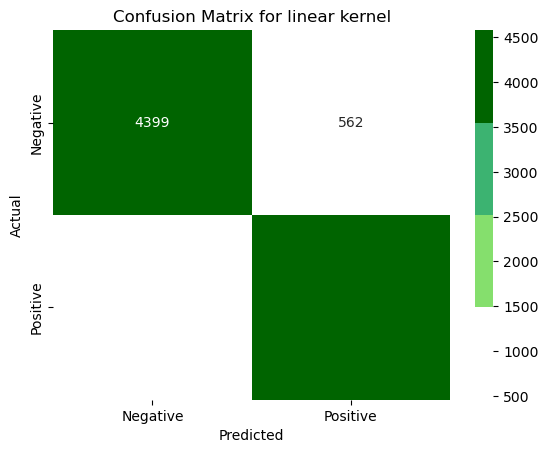

In [14]:
import matplotlib as mat

# Classification Report
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=['Negative', 'Positive']), end = "\t")

# Calculate the accuracy score
acc = accuracy_score(y_test, y_pred)
print(f"Accuracy: {acc * 100:.2f}%")

# Display the confusion matrix
cm = confusion_matrix(y_test, y_pred)
cmap = mat.colors.ListedColormap(['#ffffff', '#85df6d', '#3cb371', '#006400'])

sns.heatmap(cm, annot = True, fmt = 'd', cmap = cmap,
            xticklabels=['Negative', 'Positive'],
            yticklabels=['Negative', 'Positive'])
plt.title('Confusion Matrix for linear kernel')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [ ]:
# Taking custom input
message = input()

# Data preprocessing and vectorization
message = lemmatize_data(clean_data(message))
message = vec.transform([message])

# Displaying prediction
pred = clf.predict(message)

match pred:
    case 0:
        print('negative')
    case 1:
        print('positive')